# GNSS Review

In [1]:
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool, BoxZoomTool
from bokeh.plotting import figure, show, save
from bokeh.io import output_notebook, export_png
import pandas as pd
import numpy as np
import pymap3d as pm
import matplotlib.pyplot as plt

from plots import plotLineTimeRange, plotHist, plotEN_pyplot, plot_hist_pyplot

output_notebook()

Loading BokehJS ...

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from logparser import LogReader

In [3]:
#filepath = "./.data/log_mimir_20230715122058.txt"

deviceName = "Google Pixel 7"
filepath = "../.data/gnss_log_2023_04_14_15_23_32.txt"
time_range = ('2023-04-14 12:23:30','2023-04-14 12:30:00')

# deviceName = "Google Pixel 7"
# filepath = "./.data/gnss_log_2023_03_03_10_29_45.txt"
# time_range = ('2023-03-03 08:29:47.000','2023-03-03 08:33:00.000')

# deviceName = "Xiaomi 11"
# filepath = "./.data/gnss_log_2023_03_03_09_56_06.txt"
# time_range = ('2023-03-03 07:56:12.000','2023-03-03 08:41:11.000')

log = LogReader(filepath, ['Raw', 'Fix'])

#log.fix


## Pseudorange Analysis

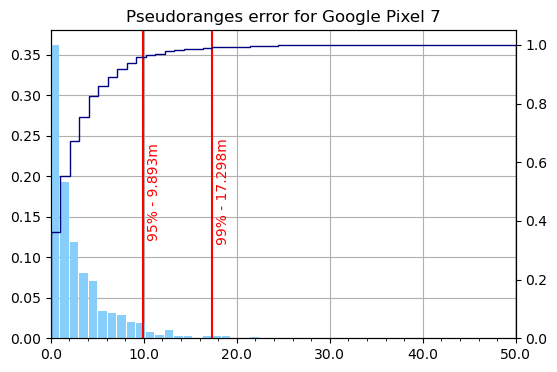

In [4]:
# Turn to time serie
ts = log.raw.set_index('datetime')

data_name = 'PseudorangeAcceleration'

sats = list(set(ts["prn"]))
sats.sort()
sats = [item for item in sats if item.startswith('G')]
sats = ['G02-L1']

_ts = ts.loc[ts['prn'].isin(sats), [data_name, 'prn']]

# Filter
# _ts[data_name] = _ts[data_name].abs()
# q = _ts[data_name].quantile(0.99)
# _ts = _ts[ts[data_name] < q] 

p = plotHist(_ts, data_name)
show(p)
#save(p, filename="pseudo_error_Galileo.html")
#export_png(p, filename="pseudo_error_Galileo.png")

plot_hist_pyplot(_ts, data_name, lim=50)
plt.title(f'Pseudoranges error for {deviceName}')
plt.margins(x=0)
plt.xlim(0,50)
plt.show()


# Position analysis

In [5]:
def convert2ENU(lat, lon, alt, ref):
    east, north, up = pm.geodetic2enu(lat, lon, alt, ref[0], ref[1], ref[2])
    return {"east":east, "north":north, "up":up}

def getHorizontalError(north, east):
    error = np.sqrt(north**2 + east**2)
    return {"2D_error":error}

<Figure size 800x800 with 0 Axes>

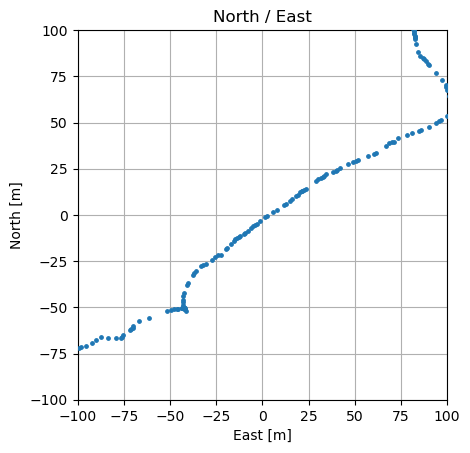

,latitude,longitude,altitude,east,north,up
datetime,,,,,,
2023-04-14 12:23:31.999,61.449453,23.856857,163.708172,82.623329,96.230809,-2.132610
2023-04-14 12:23:32.999,61.449454,23.856856,163.596046,82.613496,96.281457,-2.244736
2023-04-14 12:23:34.999,61.449454,23.856856,163.420326,82.574146,96.348640,-2.420458
2023-04-14 12:23:35.999,61.449455,23.856855,163.271978,82.556471,96.386660,-2.568806
2023-04-14 12:23:37.999,61.449456,23.856855,162.983347,82.531692,96.526712,-2.857438
...,...,...,...,...,...,...
2023-04-14 12:29:53.000,61.447810,23.852820,168.754296,-132.705975,-86.856068,2.912805
2023-04-14 12:29:54.000,61.447803,23.852799,168.728019,-133.802709,-87.665054,2.886494
2023-04-14 12:29:57.000,61.447786,23.852768,167.785670,-135.471205,-89.619847,1.944083


In [6]:

pos = log.fix.loc[log.fix['provider'].isin(['GPS']), ['datetime', 'latitude', 'longitude', 'altitude']]
pos = pos.set_index('datetime')

pos = pos.loc[time_range[0]:time_range[1]]

ref_enu = [pos['latitude'].mean(), pos['longitude'].mean(), pos['altitude'].mean()]

pos[["east", "north", "up"]] = pos.apply(
    lambda row: convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
    axis='columns', result_type='expand')

plotEN_pyplot(pos, 100)

pos 

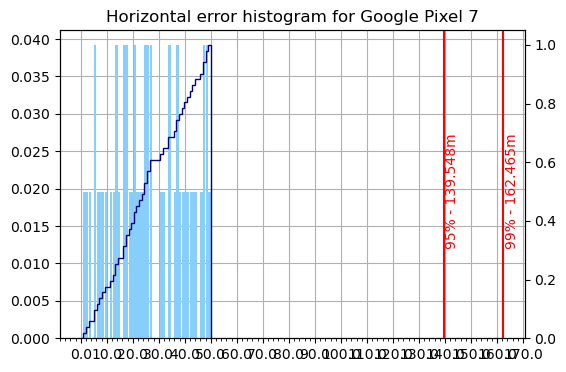

In [7]:
#plot_hist_pyplot(pos, 'east', lim=np.max(np.abs(ts[data_name])))

pos[["2D_error"]] = pos.apply(
    lambda row: getHorizontalError(row['north'], row['east']), 
    axis='columns', result_type='expand')

plot_hist_pyplot(pos, '2D_error', lim=50)
plt.title(f'Horizontal error histogram for {deviceName}')
plt.show()